In [ ]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '1'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [1]


In [2]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from distrax._src.distributions.distribution import Distribution
from distrax._src.bijectors.bijector import Bijector

import sys

from blackjax import normal_random_walk, hmc, nuts, elliptical_slice
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

sys.path.append('/scratch/big/home/maxhin/Documents/Repos/bamojax')

from bamojax.base import Node, Model
from bamojax.sampling import gibbs_sampler, mcmc_inference_loop, smc_inference_loop, mcmc_sampler


print('Python version:     ', sys.version)
print('Jax version:        ', jax.__version__)
print('BlackJax version:   ', blackjax.__version__)
print('Distrax version:    ', dx.__version__)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Python version:      3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:         0.4.35
BlackJax version:    1.2.4
Distrax version:     0.1.5
Jax default backend: gpu
Jax devices:         [CudaDevice(id=0)]


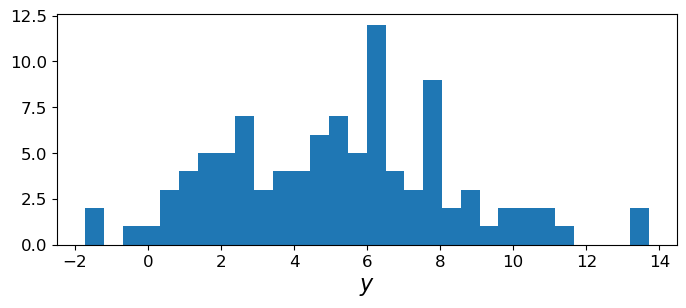

In [27]:
def guk_lml(y, sd, mu0, tau):
    # See https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
    y_bar = jnp.mean(y)
    n = len(y)
    return jnp.log(sd) - n/2*jnp.log(2*jnp.pi*sd**2) - 1/2*jnp.log(n*tau**2 + sd**2) - jnp.sum(y**2) / (2*sd**2) - mu0 / (2*tau**2) + (tau**2 * n**2 * y_bar**2 / sd**2 + sd**2*mu0**2 / tau**2 + 2*n*y_bar*mu0) / (2*(n*tau**2 + sd**2))
    
#
def exact_posterior(y, sd, mu0, sd0) -> dx.Distribution:
    """For this simple model, the exact posterior is available (given a Gaussian prior on the mean), which allows us to compare the approximate SMC result with a ground truth.
    
    """
    n = len(y)
    sd_post = 1.0 / (1/sd0**2 + n  / sd**2)
    mu_post = sd_post*(mu0 / sd0**2 + jnp.sum(y) / sd**2)
    return dx.Normal(loc=mu_post, scale=jnp.sqrt(sd_post))

#
# Generate some data

key = jrnd.PRNGKey(5678)
key, key_data, key_inference = jrnd.split(key, 3)

true_mean = 5.0
true_sd = 3.0

n = 100

y = dx.Normal(loc=true_mean, scale=true_sd).sample(seed=key_data, sample_shape=(n, ))

plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.hist(y, bins=30)
ax.set_xlabel(r'$y$');

In [28]:
mu0 = 0.0
sd0 = 2.0

gukmodel = Model('Gaussian with unknown mean')
unknown_mean = gukmodel.add_node('mu', distribution=dx.Normal(loc=mu0, scale=sd0))
observations = gukmodel.add_node('y', distribution=dx.Normal, observations=y, parents=dict(loc=unknown_mean, scale=true_sd))

In [29]:
num_particles = 100_000
num_mcmc_steps = 1_000
num_chains = 1

stepsize = 0.01

mcmc_params = dict(sigma=stepsize*jnp.eye(gukmodel.get_model_size()))
rmh = mcmc_sampler(gukmodel, mcmc_kernel=normal_random_walk, mcmc_parameters=mcmc_params)

exact_lml = guk_lml(mu0=mu0, tau=sd0, sd=true_sd, y=y)

print(f'Log marginal likelihood exact: {exact_lml:0.2f}')

final_state, lml, num_adapt, final_info = smc_inference_loop(key_inference, 
                                model=gukmodel, 
                                kernel=rmh,
                                num_particles=num_particles, 
                                num_mcmc_steps=num_mcmc_steps, 
                                num_chains=num_chains,
                                target_ess=0.5)
print(f'Log marginal likelihood SMC estimate ({num_particles} particles): {lml:0.2f}')
print(f'Number of SMC cycles: {num_adapt}')

# print(num_adapt)

Log marginal likelihood exact: -261.16
Log marginal likelihood SMC estimate (100000 particles): -261.15
Number of SMC cycles: 18


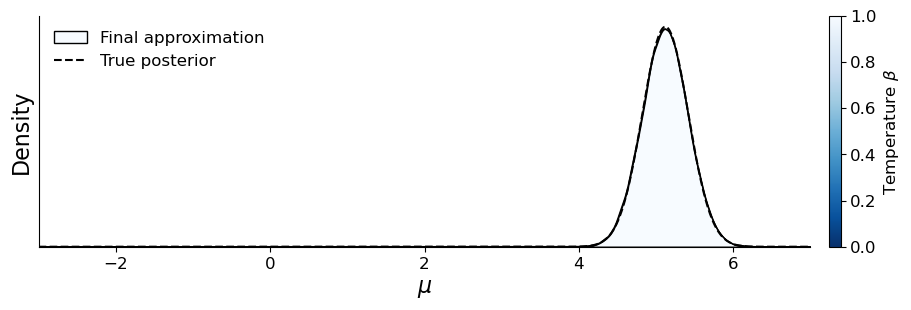

In [22]:
from jax.scipy.stats import gaussian_kde
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def plot_particles(ax, pdf, color, zorder=1.0, alpha=1.0, label=''):
    # ax.plot(mu_range, pdf(mu_range), lw=1, color='k', zorder=zorder)
    ax.fill_between(mu_range, pdf(mu_range), jnp.zeros_like(mu_range), alpha=alpha, color=color, zorder=zorder, label=label)
    ax.plot(mu_range, pdf(mu_range), lw=1, color='k', zorder=zorder)

#

xlim = [-3, 7]
mu_range = jnp.linspace(*xlim, num=1000)

cmap = plt.get_cmap('Blues_r')
norm = Normalize(vmin=0, vmax=1.0)

plt.figure(figsize=(12, 3))
ax = plt.gca()

# for i, b in enumerate(bridges):    
#     pdf = gaussian_kde(trace['mu'][b, :].flatten())
#     plot_particles(ax, pdf, cmap(norm(i/B)), zorder=i, alpha=0.8)

pdf = gaussian_kde(final_state.particles['mu'].flatten())
plot_particles(ax, pdf, cmap(norm(1.0)), zorder=999, label='Final approximation')

posterior = exact_posterior(y=y, sd=true_sd, mu0=mu0, sd0=sd0)
pdf_post = posterior.prob(mu_range)
ax.plot(mu_range, pdf_post, ls='--', color='k', zorder=9999, label='True posterior')

ax.set_xlabel(r'$\mu$', fontsize=MEDIUM_SIZE)
ax.set_ylabel(r'Density', fontsize=MEDIUM_SIZE)
ax.set_ylim(bottom=0)
for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_zorder(999999)
ax.set_xlim(*xlim)
ax.set_yticklabels([])
ax.set_yticks([])

handles, labels = ax.get_legend_handles_labels()
handles[0].set_edgecolor('k')
ax.legend(handles, labels, fontsize=SMALL_SIZE, frameon=False)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label(r'Temperature $\beta$', fontsize=SMALL_SIZE)



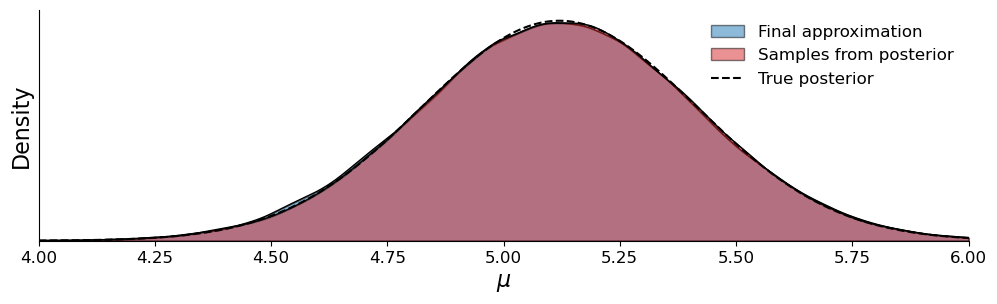

In [23]:
xlim = [4, 6]
mu_range = jnp.linspace(*xlim, num=1000)

samples_from_posterior = posterior.sample(seed=jrnd.PRNGKey(42), sample_shape=(num_particles,))

pdf_post_samples = gaussian_kde(samples_from_posterior)

plt.figure(figsize=(12, 3))
ax = plt.gca()

pdf = gaussian_kde(final_state.particles['mu'].flatten())
plot_particles(ax, pdf, 'tab:blue', zorder=999, label='Final approximation', alpha=0.5)

plot_particles(ax, pdf_post_samples, 'tab:red', zorder=999, label='Samples from posterior', alpha=0.5)

posterior = exact_posterior(y=y, sd=true_sd, mu0=mu0, sd0=sd0)
pdf_post = posterior.prob(mu_range)
ax.plot(mu_range, pdf_post, ls='--', color='k', zorder=9999, label='True posterior')


ax.set_xlabel(r'$\mu$', fontsize=MEDIUM_SIZE)
ax.set_ylabel(r'Density', fontsize=MEDIUM_SIZE)
ax.set_ylim(bottom=0)
for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_zorder(999999)
ax.set_xlim(*xlim)
ax.set_yticklabels([])
ax.set_yticks([])

handles, labels = ax.get_legend_handles_labels()
handles[0].set_edgecolor('k')
handles[1].set_edgecolor('k')
ax.legend(handles, labels, fontsize=SMALL_SIZE, frameon=False)

In [30]:
true_lml = guk_lml(mu0=mu0, tau=sd0, sd=true_sd, y=y)

print(f'Log marginal likelihood exact: {true_lml:0.2f}')
print(f'Log marginal likelihood SMC estimate: {lml:0.2f}')

Log marginal likelihood exact: -261.16
Log marginal likelihood SMC estimate: -261.15
